<a href="https://colab.research.google.com/github/uu-sml/wasp-assigninmen-af-classification/blob/main/assignment_ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Niklas Gunnarsson, Carl Andersson, Daniel Gedon

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color='red'>Yifan Ding & Nithesh Chandher Karthikeyan</font>

- **Team ID:** <font color='red'>waitwhat</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health. 
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam. 


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/42324/assignments/254507

**Due Date:** August 25, 2023.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks. 

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long. 

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [2]:
%%capture --no-display
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

In [3]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels. 
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [4]:
# 1. Download dataset
if not exists('codesubset.tar.gz'):
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

codesubset.tar.gz already exits. Using cached. Delete it manually to recieve it again!


In [5]:
# 1. unzip the downloaded data set folder
if not exists('codesubset'):
    !tar -xf codesubset.tar.gz

codesubset already exits. Using cached. Delete it manually to recieve it again!


Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [6]:
# 2. clone the code files for data preprocessing
if not exists('ecg-preprocessing'):
    !git clone https://github.com/antonior92/ecg-preprocessing.git

ecg-preprocessing already exits. Using cached. Delete it manually to recieve it again!


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

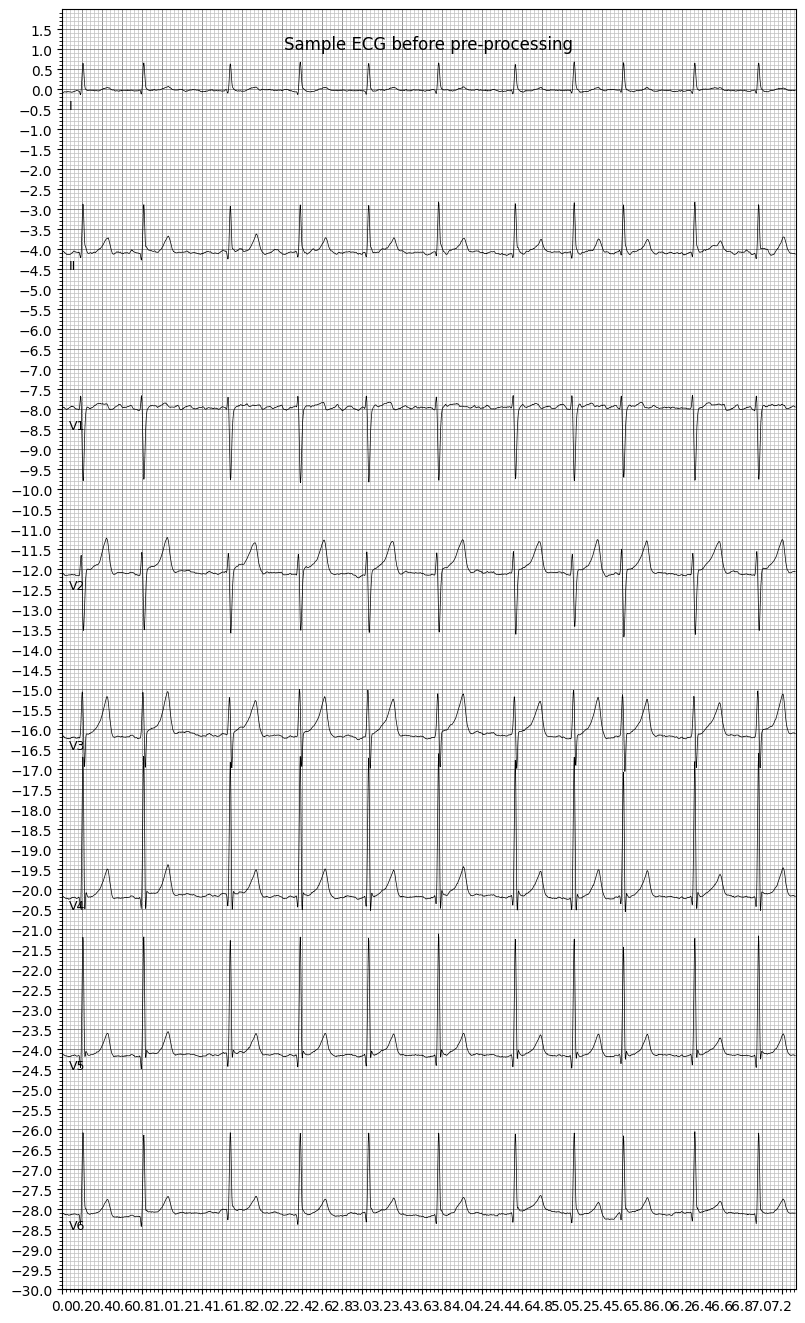

In [7]:
import ecg_plot
exec(open("ecg-preprocessing/read_ecg.py").read())

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')


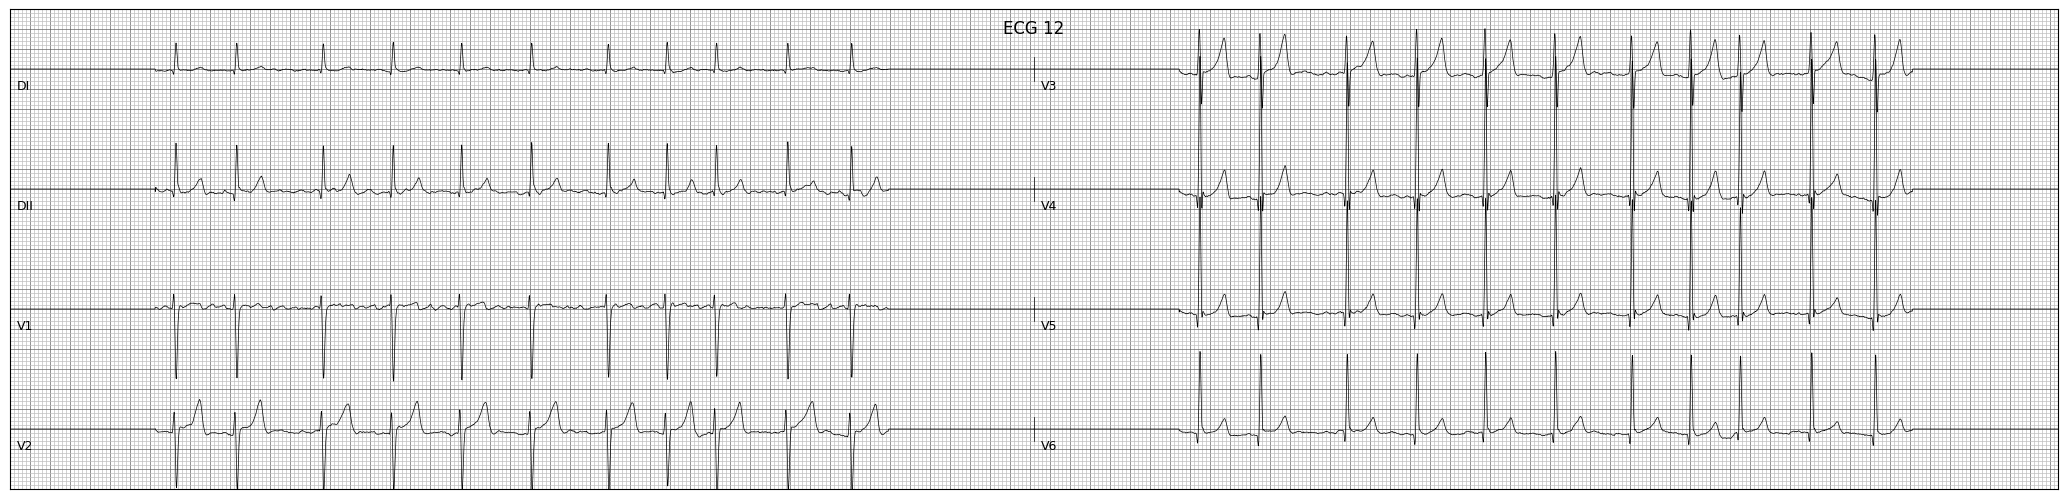

<Figure size 640x480 with 0 Axes>

In [8]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8. 
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [9]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python3 ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python3 ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

codesubset/train.h5 already exits. Using cached. Delete it manually to recieve it again!
codesubset/test.h5 already exits. Using cached. Delete it manually to recieve it again!


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


<Figure size 640x480 with 0 Axes>

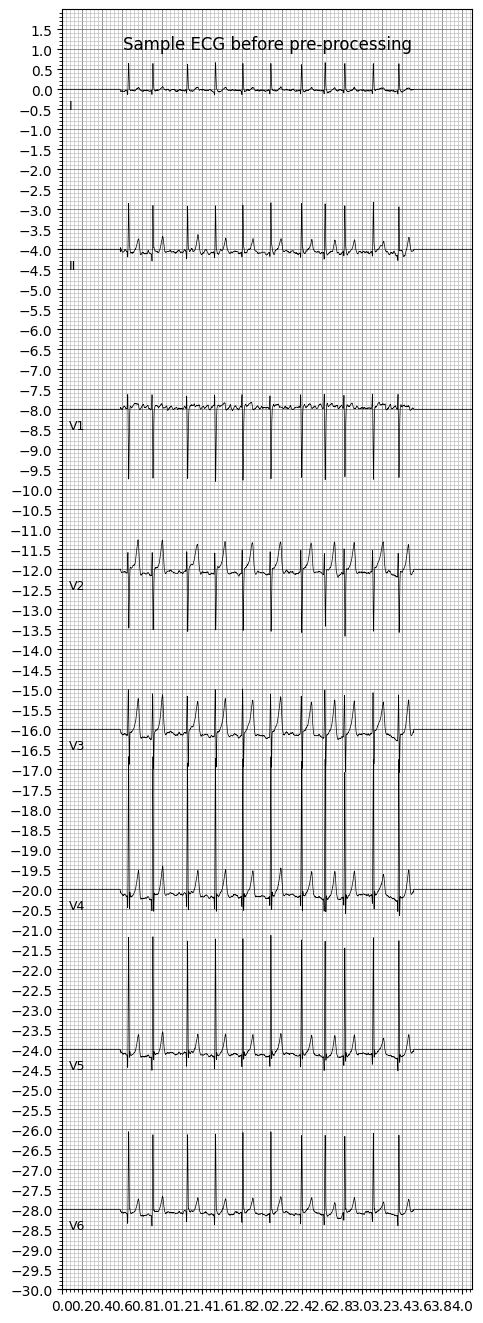

In [10]:
"""
TASK: Insert your code here
"""
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']

# ECG plot
plt.figure()
ecg_plot.plot(np.transpose(data[0]), sample_rate=1000, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()

In [11]:
#Labels
labels = pd.read_csv("codesubset/train.csv")

print("Total number of traces in the training dataset:", data.shape[0])
print("\nDistribution:",labels["AF"].value_counts())
print("\nDistribution:",labels["sex"].value_counts())
print("\nDistribution: age\n",labels["age"].describe())

def naive_classifier(size):
    predict = np.ones(size)
    return predict

def random_classifier(size):
    predict = np.random.randint(2, size=(size))
    return predict

actual = labels["AF"].to_numpy()
predict1 = naive_classifier(len(actual))
predict2 = random_classifier(len(actual))
accuracy1 = (actual == predict1).sum()/len(actual)
accuracy2 = (actual == predict2).sum()/len(actual)
print("\nPerformance of the naive classifier which always predict 1:",accuracy1)
print("\nPerformance of the random classifier:",accuracy2)

Total number of traces in the training dataset: 10000

Distribution: AF
0    7000
1    3000
Name: count, dtype: int64

Distribution: sex
F    6307
M    3693
Name: count, dtype: int64

Distribution: age
 count    10000.000000
mean        57.929600
std         17.921952
min         17.000000
25%         45.000000
50%         60.000000
75%         72.000000
max        103.000000
Name: age, dtype: float64

Performance of the naive classifier which always predict 1: 0.3

Performance of the random classifier: 0.5058


### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />


**<font color='red'>Your explanation here:</font>**

#### Data Analysis:

#### 1. Class Imbalance in Atrial Fibrillation (AF) data:
The dataset consist of 10,000 Electrocardiogram (ECG) samples. Among these samples, 7,000 patients have been tested negative for atrial fibrillation (AF), while the remaining 3,000 patients have been identified as having tested positive for AF. This division in test results highlights the presence of a class imbalance within the dataset, but the difference is not too large. But it is advisable to ensure a balanced data for model training and accurate predictions. 

#### 2. Gender Distribution Disparity:
Additionally, the dataset also exhibits an uneven distribution in terms of gender representation. It has been observed that there are more samples from female patients compared to male patients. This disparity could potentially introduce bias in the analysis, as certain medical conditions might present differently in different genders. 

#### 3. Age Diversity in the Dataset:
The dataset encompasses a wide range of ages among the patients. The age group of the samples spans from a minimum of 17 years to a maximum of 103 years. This diversity in age not only reflects the variability in the population being studied but also presents an opportunity to explore how the presence of atrial fibrillation might manifest across different age groups.


#### Data Preprocessing:

1. Resampling all ECG traces to the sample sampling period (400 Hz) makes the data normalised and aligned for more accurate comparison.

2. Zero padding if necessary to get a uniform sample/signal length of 4096, leads to input data of same size.

3. Removing trends in the ECG signal helps in focusing on the underlying heart activity rather than any extraneous variations.

4. Removing possible power line noises enhances accuracy and maintain signal quality by eliminating interference from electromagnetic sources.

---
## Model

The model class consists of two methods: 
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations: 
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [12]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8, 
                               out_channels=32, 
                               kernel_size=self.kernel_size, 
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)
        
        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)
        
        # ReLU
        self.relu = nn.ReLU()


    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)
        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [13]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.kernel_size = 30

        # conv layer
        downsample1 = self._downsample(4096, 2048)
        self.conv1 = nn.Conv1d(in_channels=8, 
                               out_channels=128, 
                               kernel_size=self.kernel_size, 
                               stride=downsample1,
                               padding=self._padding(downsample1),
                               bias=True)
        
        self.bn1 = nn.BatchNorm1d(128)
        
        downsample2 = self._downsample(2048, 1024)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256,
                              kernel_size=self.kernel_size,
                              stride=downsample2,
                              padding=self._padding(downsample2),
                              bias=True)
        
        self.bn2 = nn.BatchNorm1d(256)
        
        downsample3 = self._downsample(1024, 512)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=512,
                              kernel_size=self.kernel_size,
                              stride=downsample3,
                              padding=self._padding(downsample3),
                              bias=True)
        
        self.bn3 = nn.BatchNorm1d(512)
        
        downsample4 = self._downsample(512, 256)
        self.conv4 = nn.Conv1d(in_channels=512, out_channels=512,
                              kernel_size=self.kernel_size,
                              stride=2,
                              padding=self._padding(downsample4),
                              bias=True)
        
        self.bn4 = nn.BatchNorm1d(512)
        
        downsample5 = self._downsample(256, 128)
        self.conv5 = nn.Conv1d(in_channels=512, out_channels=512,
                              kernel_size=self.kernel_size,
                              stride=2,
                              padding=self._padding(downsample5),
                              bias=True)
        
        self.bn5 = nn.BatchNorm1d(512)
        
        # max
        self.maxpool = nn.MaxPool1d(3)
        
        # ReLU
        self.relu = nn.ReLU()
        
        # linear layer
        self.lin = nn.Linear(in_features=512*51,
                             out_features=1)
        

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.relu(self.conv4(x))
        x = self.bn4(x)
        #x = self.relu(self.conv5(x))
        #x = self.bn5(x)
        x = self.maxpool(x)
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**
We created a deep network using the same principle as the baseline model. Below are some explanations of our model:

1. There are four conv layers that gradually downsamples the input traces from 4096 samples to 128 samples and also increases the number of channels from 8 (=number of leads) to 512. Deeper network helps to learn more features from the data. 

2. Large kernel size (30) is chosen to capture more receptive field.

3. Conv layers are followed by a BatchNorm layers for faster and stable training.

4. MaxPool layer is used to reduce the dimensions before the linear layer at the end that flattens output from the MaxPool layer and outputs one prediction.

---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [14]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        """
        TASK: Insert your code here. This task can be done in 5 lines of code.
        """
        optimizer.zero_grad()
        outputs = model(traces)
        loss = loss_function(outputs,diagnoses)
        loss.backward()
        optimizer.step()

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    train_pbar.close()
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [15]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_pred, valid_true = [], []
    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code.
        """
        with torch.no_grad():
            valid_pred = model(traces)
            valid_true = diagnoses
            loss = loss_function(valid_pred,valid_true)
            valid_pred = valid_pred.cpu().numpy()
            valid_true = valid_true.cpu().numpy()
        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_pred), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**

#### Learning Rate = 3e-4
The initial learning rate value is set to 1e-1. The choice to reduce the learning rate is due to the large initial value causing instability in training. This instability is characterized by the loss increasing after a few epochs, which is a sign of overshooting. By opting for a smaller learning rate of 3e-4, the training process becomes more controlled and better converges to an optimal solution.

#### Weight Decay=1e-1
Weight decay is the regularization technique that helps to limit the complexity of the model by penalizing large weight values, leading to a more generalized model and avoids overfitting. We didn't change it and kept the default value in the notebook file. 

#### Epochs=200
Epochs determines the number of training iteration. Since the learning rate is small, and the training method saves the best model, we experimented by choosing a higher value.

#### Batch Size=128
The larger batch size is chosen to increase training speed

#### Loss Function: BCEWithLogitsLoss
BCEWithLogitsLoss combines Binary Cross Entropy loss function and the sigmoid activation into one layer for efficient gradient computation. It's well-suited for binary classification tasks where the model outputs logits that need to be transformed into probabilities.

#### Optimizer: Adam
It is a popular and versatile optimizer choice for neural network training, that incorporates the concepts from RMSProp and SGD Momentum

#### Learning Rate Scheduler: None
No learning rate scheduler is employed in our experiments.

#### Train-valid split: 90:10
The dataset is split into a 90% training set and a 10% validation set. This allows for model training on the larger training dataset while reserving a smaller portion for evaluation to assess the model's performance.

In [16]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
learning_rate = 3e-4  
weight_decay = 1e-1  
num_epochs = 200
batch_size = 128

In [17]:
from torch.utils.data import TensorDataset, random_split, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [9000, 1000])
# build data loaders
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)                         

tqdm.write("Done!\n")

Use device: cuda

Building data loaders...
Done!



Define model...
Done!

Define optimiser...
Done!

Training...


  0%|          | 0/200 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.003147 	Valid Loss 0.001834 	Best model -> saved


Training Epoch  2:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.001672 	Valid Loss 0.001184 	Best model -> saved


Training Epoch  3:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.001487 	Valid Loss 0.001006 	Best model -> saved


Training Epoch  4:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.001321 	Valid Loss 0.001164 	


Training Epoch  5:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.001300 	Valid Loss 0.005656 	


Training Epoch  6:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.001226 	Valid Loss 0.001765 	


Training Epoch  7:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.001223 	Valid Loss 0.001196 	


Training Epoch  8:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.001184 	Valid Loss 0.002215 	


Training Epoch  9:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.001273 	Valid Loss 0.001082 	


Training Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.001201 	Valid Loss 0.001697 	


Training Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.001148 	Valid Loss 0.001706 	


Training Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.001161 	Valid Loss 0.000785 	Best model -> saved


Training Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.001082 	Valid Loss 0.001444 	


Training Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.001123 	Valid Loss 0.003905 	


Training Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.001140 	Valid Loss 0.003778 	


Training Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16: 	Train Loss 0.001081 	Valid Loss 0.004603 	


Training Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17: 	Train Loss 0.001078 	Valid Loss 0.000845 	


Training Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18: 	Train Loss 0.001163 	Valid Loss 0.005016 	


Training Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19: 	Train Loss 0.001080 	Valid Loss 0.001228 	


Training Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20: 	Train Loss 0.001196 	Valid Loss 0.004134 	


Training Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21: 	Train Loss 0.001050 	Valid Loss 0.000771 	Best model -> saved


Training Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22: 	Train Loss 0.001041 	Valid Loss 0.001202 	


Training Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23: 	Train Loss 0.001078 	Valid Loss 0.003021 	


Training Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24: 	Train Loss 0.001024 	Valid Loss 0.003542 	


Training Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25: 	Train Loss 0.001193 	Valid Loss 0.018275 	


Training Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26: 	Train Loss 0.001096 	Valid Loss 0.001317 	


Training Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27: 	Train Loss 0.001048 	Valid Loss 0.001382 	


Training Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28: 	Train Loss 0.001040 	Valid Loss 0.000929 	


Training Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29: 	Train Loss 0.001021 	Valid Loss 0.000960 	


Training Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30: 	Train Loss 0.001126 	Valid Loss 0.002933 	


Training Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 31: 	Train Loss 0.001067 	Valid Loss 0.002082 	


Training Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 32: 	Train Loss 0.001105 	Valid Loss 0.001544 	


Training Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 33: 	Train Loss 0.001095 	Valid Loss 0.000972 	


Training Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 34: 	Train Loss 0.001046 	Valid Loss 0.001189 	


Training Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 35: 	Train Loss 0.001024 	Valid Loss 0.002952 	


Training Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 36: 	Train Loss 0.001136 	Valid Loss 0.001176 	


Training Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 37: 	Train Loss 0.001037 	Valid Loss 0.003186 	


Training Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 38: 	Train Loss 0.000999 	Valid Loss 0.001786 	


Training Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 39: 	Train Loss 0.001062 	Valid Loss 0.001760 	


Training Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 40: 	Train Loss 0.001021 	Valid Loss 0.001117 	


Training Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 41: 	Train Loss 0.001021 	Valid Loss 0.004150 	


Training Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 42: 	Train Loss 0.001249 	Valid Loss 0.001116 	


Training Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 43: 	Train Loss 0.000977 	Valid Loss 0.002415 	


Training Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 44: 	Train Loss 0.000915 	Valid Loss 0.001378 	


Training Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 45: 	Train Loss 0.000905 	Valid Loss 0.001715 	


Training Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 46: 	Train Loss 0.000919 	Valid Loss 0.000878 	


Training Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 47: 	Train Loss 0.000892 	Valid Loss 0.001234 	


Training Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 48: 	Train Loss 0.000928 	Valid Loss 0.001259 	


Training Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 49: 	Train Loss 0.000861 	Valid Loss 0.002157 	


Training Epoch 50:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 50: 	Train Loss 0.000862 	Valid Loss 0.000882 	


Training Epoch 51:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 51: 	Train Loss 0.000877 	Valid Loss 0.002510 	


Training Epoch 52:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 52: 	Train Loss 0.000903 	Valid Loss 0.001182 	


Training Epoch 53:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 53: 	Train Loss 0.000798 	Valid Loss 0.001281 	


Training Epoch 54:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 54: 	Train Loss 0.000856 	Valid Loss 0.000708 	Best model -> saved


Training Epoch 55:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 55: 	Train Loss 0.000870 	Valid Loss 0.001006 	


Training Epoch 56:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 56: 	Train Loss 0.000815 	Valid Loss 0.000840 	


Training Epoch 57:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 57: 	Train Loss 0.000794 	Valid Loss 0.002860 	


Training Epoch 58:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 58: 	Train Loss 0.000829 	Valid Loss 0.001609 	


Training Epoch 59:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 59: 	Train Loss 0.000792 	Valid Loss 0.000635 	Best model -> saved


Training Epoch 60:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 60: 	Train Loss 0.000806 	Valid Loss 0.000980 	


Training Epoch 61:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 61: 	Train Loss 0.000768 	Valid Loss 0.001663 	


Training Epoch 62:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 62: 	Train Loss 0.000789 	Valid Loss 0.002176 	


Training Epoch 63:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 63: 	Train Loss 0.000827 	Valid Loss 0.000861 	


Training Epoch 64:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 64: 	Train Loss 0.000807 	Valid Loss 0.000730 	


Training Epoch 65:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 65: 	Train Loss 0.000771 	Valid Loss 0.000624 	Best model -> saved


Training Epoch 66:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 66: 	Train Loss 0.000775 	Valid Loss 0.000671 	


Training Epoch 67:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 67: 	Train Loss 0.000779 	Valid Loss 0.000971 	


Training Epoch 68:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 68: 	Train Loss 0.000727 	Valid Loss 0.000759 	


Training Epoch 69:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 69: 	Train Loss 0.000733 	Valid Loss 0.000850 	


Training Epoch 70:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 70: 	Train Loss 0.000753 	Valid Loss 0.000630 	


Training Epoch 71:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 71: 	Train Loss 0.000799 	Valid Loss 0.000799 	


Training Epoch 72:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 72: 	Train Loss 0.000772 	Valid Loss 0.000595 	Best model -> saved


Training Epoch 73:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 73: 	Train Loss 0.000752 	Valid Loss 0.000624 	


Training Epoch 74:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 74: 	Train Loss 0.000756 	Valid Loss 0.000613 	


Training Epoch 75:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 75: 	Train Loss 0.000756 	Valid Loss 0.000795 	


Training Epoch 76:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 76: 	Train Loss 0.000732 	Valid Loss 0.000504 	Best model -> saved


Training Epoch 77:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 77: 	Train Loss 0.000745 	Valid Loss 0.000662 	


Training Epoch 78:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 78: 	Train Loss 0.000726 	Valid Loss 0.000541 	


Training Epoch 79:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 79: 	Train Loss 0.000728 	Valid Loss 0.000709 	


Training Epoch 80:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 80: 	Train Loss 0.000712 	Valid Loss 0.000498 	Best model -> saved


Training Epoch 81:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 81: 	Train Loss 0.000718 	Valid Loss 0.000618 	


Training Epoch 82:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 82: 	Train Loss 0.000759 	Valid Loss 0.000717 	


Training Epoch 83:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 83: 	Train Loss 0.000740 	Valid Loss 0.000512 	


Training Epoch 84:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 84: 	Train Loss 0.000715 	Valid Loss 0.000687 	


Training Epoch 85:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 85: 	Train Loss 0.000719 	Valid Loss 0.000687 	


Training Epoch 86:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 86: 	Train Loss 0.000708 	Valid Loss 0.000601 	


Training Epoch 87:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 87: 	Train Loss 0.000726 	Valid Loss 0.000645 	


Training Epoch 88:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 88: 	Train Loss 0.000705 	Valid Loss 0.000705 	


Training Epoch 89:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 89: 	Train Loss 0.000692 	Valid Loss 0.000452 	Best model -> saved


Training Epoch 90:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 90: 	Train Loss 0.000646 	Valid Loss 0.000554 	


Training Epoch 91:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 91: 	Train Loss 0.000704 	Valid Loss 0.000443 	Best model -> saved


Training Epoch 92:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 92: 	Train Loss 0.000718 	Valid Loss 0.001107 	


Training Epoch 93:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 93: 	Train Loss 0.000698 	Valid Loss 0.000522 	


Training Epoch 94:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 94: 	Train Loss 0.000686 	Valid Loss 0.000496 	


Training Epoch 95:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 95: 	Train Loss 0.000692 	Valid Loss 0.001074 	


Training Epoch 96:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 96: 	Train Loss 0.000677 	Valid Loss 0.000488 	


Training Epoch 97:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 97: 	Train Loss 0.000663 	Valid Loss 0.000644 	


Training Epoch 98:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 98: 	Train Loss 0.000699 	Valid Loss 0.000655 	


Training Epoch 99:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 99: 	Train Loss 0.000682 	Valid Loss 0.000625 	


Training Epoch 100:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 100: 	Train Loss 0.000662 	Valid Loss 0.000696 	


Training Epoch 101:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 101:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 101: 	Train Loss 0.000658 	Valid Loss 0.000727 	


Training Epoch 102:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 102:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 102: 	Train Loss 0.000652 	Valid Loss 0.000585 	


Training Epoch 103:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 103:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 103: 	Train Loss 0.000656 	Valid Loss 0.001261 	


Training Epoch 104:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 104:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 104: 	Train Loss 0.000676 	Valid Loss 0.000457 	


Training Epoch 105:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 105:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 105: 	Train Loss 0.000644 	Valid Loss 0.000511 	


Training Epoch 106:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 106:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 106: 	Train Loss 0.000650 	Valid Loss 0.000691 	


Training Epoch 107:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 107:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 107: 	Train Loss 0.000669 	Valid Loss 0.000622 	


Training Epoch 108:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 108:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 108: 	Train Loss 0.000658 	Valid Loss 0.001078 	


Training Epoch 109:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 109:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 109: 	Train Loss 0.000686 	Valid Loss 0.000530 	


Training Epoch 110:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 110:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 110: 	Train Loss 0.000657 	Valid Loss 0.000551 	


Training Epoch 111:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 111:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 111: 	Train Loss 0.000682 	Valid Loss 0.000709 	


Training Epoch 112:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 112:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 112: 	Train Loss 0.000691 	Valid Loss 0.000724 	


Training Epoch 113:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 113:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 113: 	Train Loss 0.000686 	Valid Loss 0.000510 	


Training Epoch 114:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 114:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 114: 	Train Loss 0.000659 	Valid Loss 0.000493 	


Training Epoch 115:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 115:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 115: 	Train Loss 0.000642 	Valid Loss 0.000594 	


Training Epoch 116:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 116:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 116: 	Train Loss 0.000698 	Valid Loss 0.000617 	


Training Epoch 117:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 117:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 117: 	Train Loss 0.000659 	Valid Loss 0.000572 	


Training Epoch 118:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 118:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 118: 	Train Loss 0.000685 	Valid Loss 0.000461 	


Training Epoch 119:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 119:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 119: 	Train Loss 0.000636 	Valid Loss 0.000481 	


Training Epoch 120:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 120:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 120: 	Train Loss 0.000669 	Valid Loss 0.000712 	


Training Epoch 121:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 121:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 121: 	Train Loss 0.000635 	Valid Loss 0.000506 	


Training Epoch 122:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 122:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 122: 	Train Loss 0.000664 	Valid Loss 0.000535 	


Training Epoch 123:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 123:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 123: 	Train Loss 0.000657 	Valid Loss 0.000929 	


Training Epoch 124:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 124:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 124: 	Train Loss 0.000635 	Valid Loss 0.000489 	


Training Epoch 125:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 125:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 125: 	Train Loss 0.000643 	Valid Loss 0.000527 	


Training Epoch 126:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 126:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 126: 	Train Loss 0.000650 	Valid Loss 0.001014 	


Training Epoch 127:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 127:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 127: 	Train Loss 0.000702 	Valid Loss 0.000666 	


Training Epoch 128:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 128:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 128: 	Train Loss 0.000706 	Valid Loss 0.000519 	


Training Epoch 129:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 129:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 129: 	Train Loss 0.000770 	Valid Loss 0.000721 	


Training Epoch 130:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 130:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 130: 	Train Loss 0.000647 	Valid Loss 0.000532 	


Training Epoch 131:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 131:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 131: 	Train Loss 0.000643 	Valid Loss 0.000442 	Best model -> saved


Training Epoch 132:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 132:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 132: 	Train Loss 0.000649 	Valid Loss 0.000480 	


Training Epoch 133:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 133:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 133: 	Train Loss 0.000627 	Valid Loss 0.000623 	


Training Epoch 134:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 134:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 134: 	Train Loss 0.000642 	Valid Loss 0.000480 	


Training Epoch 135:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 135:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 135: 	Train Loss 0.000625 	Valid Loss 0.000548 	


Training Epoch 136:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 136:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 136: 	Train Loss 0.000650 	Valid Loss 0.000512 	


Training Epoch 137:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 137:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 137: 	Train Loss 0.000656 	Valid Loss 0.000583 	


Training Epoch 138:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 138:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 138: 	Train Loss 0.000649 	Valid Loss 0.000556 	


Training Epoch 139:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 139:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 139: 	Train Loss 0.000656 	Valid Loss 0.000545 	


Training Epoch 140:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 140:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 140: 	Train Loss 0.000668 	Valid Loss 0.000423 	Best model -> saved


Training Epoch 141:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 141:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 141: 	Train Loss 0.000688 	Valid Loss 0.000477 	


Training Epoch 142:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 142:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 142: 	Train Loss 0.000647 	Valid Loss 0.000649 	


Training Epoch 143:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 143:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 143: 	Train Loss 0.000652 	Valid Loss 0.000546 	


Training Epoch 144:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 144:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 144: 	Train Loss 0.000635 	Valid Loss 0.000515 	


Training Epoch 145:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 145:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 145: 	Train Loss 0.000626 	Valid Loss 0.000558 	


Training Epoch 146:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 146:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 146: 	Train Loss 0.000624 	Valid Loss 0.000468 	


Training Epoch 147:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 147:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 147: 	Train Loss 0.000637 	Valid Loss 0.000627 	


Training Epoch 148:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 148:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 148: 	Train Loss 0.000648 	Valid Loss 0.000583 	


Training Epoch 149:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 149:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 149: 	Train Loss 0.000644 	Valid Loss 0.000482 	


Training Epoch 150:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 150:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 150: 	Train Loss 0.000645 	Valid Loss 0.000547 	


Training Epoch 151:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 151:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 151: 	Train Loss 0.000642 	Valid Loss 0.000542 	


Training Epoch 152:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 152:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 152: 	Train Loss 0.000678 	Valid Loss 0.000517 	


Training Epoch 153:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 153:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 153: 	Train Loss 0.000641 	Valid Loss 0.000571 	


Training Epoch 154:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 154:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 154: 	Train Loss 0.000608 	Valid Loss 0.000760 	


Training Epoch 155:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 155:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 155: 	Train Loss 0.000654 	Valid Loss 0.000646 	


Training Epoch 156:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 156:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 156: 	Train Loss 0.000686 	Valid Loss 0.000626 	


Training Epoch 157:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 157:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 157: 	Train Loss 0.000633 	Valid Loss 0.000604 	


Training Epoch 158:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 158:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 158: 	Train Loss 0.000630 	Valid Loss 0.000510 	


Training Epoch 159:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 159:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 159: 	Train Loss 0.000650 	Valid Loss 0.001226 	


Training Epoch 160:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 160:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 160: 	Train Loss 0.000649 	Valid Loss 0.000584 	


Training Epoch 161:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 161:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 161: 	Train Loss 0.000626 	Valid Loss 0.000546 	


Training Epoch 162:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 162:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 162: 	Train Loss 0.000664 	Valid Loss 0.002083 	


Training Epoch 163:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 163:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 163: 	Train Loss 0.000677 	Valid Loss 0.000937 	


Training Epoch 164:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 164:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 164: 	Train Loss 0.000680 	Valid Loss 0.000462 	


Training Epoch 165:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 165:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 165: 	Train Loss 0.000697 	Valid Loss 0.000547 	


Training Epoch 166:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 166:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 166: 	Train Loss 0.000629 	Valid Loss 0.000479 	


Training Epoch 167:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 167:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 167: 	Train Loss 0.000604 	Valid Loss 0.000450 	


Training Epoch 168:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 168:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 168: 	Train Loss 0.000599 	Valid Loss 0.000466 	


Training Epoch 169:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 169:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 169: 	Train Loss 0.000658 	Valid Loss 0.000499 	


Training Epoch 170:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 170:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 170: 	Train Loss 0.000644 	Valid Loss 0.000676 	


Training Epoch 171:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 171:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 171: 	Train Loss 0.000618 	Valid Loss 0.000646 	


Training Epoch 172:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 172:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 172: 	Train Loss 0.000613 	Valid Loss 0.000605 	


Training Epoch 173:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 173:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 173: 	Train Loss 0.000610 	Valid Loss 0.000479 	


Training Epoch 174:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 174:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 174: 	Train Loss 0.000627 	Valid Loss 0.000531 	


Training Epoch 175:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 175:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 175: 	Train Loss 0.000629 	Valid Loss 0.000524 	


Training Epoch 176:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 176:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 176: 	Train Loss 0.000605 	Valid Loss 0.000488 	


Training Epoch 177:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 177:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 177: 	Train Loss 0.000604 	Valid Loss 0.000588 	


Training Epoch 178:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 178:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 178: 	Train Loss 0.000675 	Valid Loss 0.000561 	


Training Epoch 179:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 179:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 179: 	Train Loss 0.000629 	Valid Loss 0.000896 	


Training Epoch 180:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 180:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 180: 	Train Loss 0.000653 	Valid Loss 0.000541 	


Training Epoch 181:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 181:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 181: 	Train Loss 0.000653 	Valid Loss 0.000480 	


Training Epoch 182:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 182:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 182: 	Train Loss 0.000612 	Valid Loss 0.000638 	


Training Epoch 183:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 183:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 183: 	Train Loss 0.000601 	Valid Loss 0.000459 	


Training Epoch 184:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 184:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 184: 	Train Loss 0.000614 	Valid Loss 0.000625 	


Training Epoch 185:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 185:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 185: 	Train Loss 0.000632 	Valid Loss 0.000447 	


Training Epoch 186:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 186:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 186: 	Train Loss 0.000608 	Valid Loss 0.000484 	


Training Epoch 187:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 187:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 187: 	Train Loss 0.000637 	Valid Loss 0.000486 	


Training Epoch 188:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 188:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 188: 	Train Loss 0.000629 	Valid Loss 0.000548 	


Training Epoch 189:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 189:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 189: 	Train Loss 0.000657 	Valid Loss 0.000509 	


Training Epoch 190:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 190:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 190: 	Train Loss 0.000641 	Valid Loss 0.000563 	


Training Epoch 191:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 191:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 191: 	Train Loss 0.000636 	Valid Loss 0.000485 	


Training Epoch 192:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 192:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 192: 	Train Loss 0.000608 	Valid Loss 0.000629 	


Training Epoch 193:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 193:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 193: 	Train Loss 0.000629 	Valid Loss 0.000656 	


Training Epoch 194:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 194:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 194: 	Train Loss 0.000599 	Valid Loss 0.000712 	


Training Epoch 195:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 195:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 195: 	Train Loss 0.000632 	Valid Loss 0.000663 	


Training Epoch 196:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 196:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 196: 	Train Loss 0.000608 	Valid Loss 0.000608 	


Training Epoch 197:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 197:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 197: 	Train Loss 0.000609 	Valid Loss 0.000500 	


Training Epoch 198:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 198:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 198: 	Train Loss 0.000656 	Valid Loss 0.000770 	


Training Epoch 199:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 199:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 199: 	Train Loss 0.000637 	Valid Loss 0.000479 	


Training Epoch 200:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluation Epoch 200:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 200: 	Train Loss 0.000609 	Valid Loss 0.000598 	


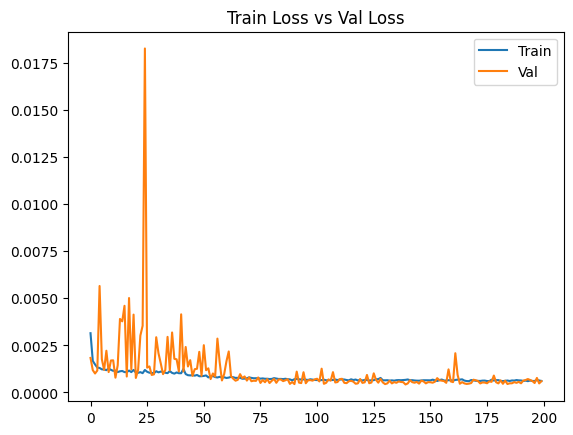

In [19]:
# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
#model = ModelBaseline()
model = Model()
model.to(device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""
loss_function = nn.BCEWithLogitsLoss()

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
lr_scheduler = None

# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all = [], []

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    """
    TASK: compute validation metrics (e.g. AUROC); Insert your code here
    This can be done e.g. in 5 lines of code
    """

    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth') 
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step()

"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""
plt.figure()
plt.plot(train_loss_all, label="Train")
plt.plot(valid_loss_all, label="Val")
plt.legend()
plt.title("Train Loss vs Val Loss")
plt.show()

---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain hard predction (0,1) instead of soft predictions (probabilities). 

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The soft and hard predictions are saved in the variables `soft_pred` and `hard_pred`.
- upload your predictions to the leaderboard online (see instruction details below). 

In [20]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [21]:
# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
#model = ModelBaseline()
model = Model()
# load stored model parameters
ckpt = torch.load('model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Define model...
Done!



Testing:   0%|          | 0/188 [00:00<?, ?it/s]

In [22]:
soft_pred

array([[0.9942142 , 0.00578582],
       [0.9903817 , 0.00961831],
       [0.9947907 , 0.00520932],
       ...,
       [0.0022409 , 0.9977591 ],
       [0.00532633, 0.99467367],
       [0.01609731, 0.9839027 ]], dtype=float32)

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [23]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

leaderboard already exits. Using cached. Delete it manually to recieve it again!


In [24]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password. 
Do not change this after you have registered your team
"""
team_id = 'waitwhat' #Fill in a string
password = 'waitwhat' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

In [25]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = 'k30-m4-200-max3' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

Submission successful!


### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />

**<font color='red'>Your explanation here:</font>**

Your team id: **<font color='red'>waitwhat</font>**

| Submission note | Accuracy | F1  | AUC | AP  |     Submission description     |
| --------------- | -------- | --  | --  | --  | ------------------------------ |                  
|8/21,k15         | 0.931    |0.929|0.979|0.976| Initial Kernel Size of 15      |
|k30-m4-200-max5  | 0.951    |0.949|0.988|0.987| Kernel=30,epoch=200 & Maxpool  |
|k30-m4-200-bn    | 0.949    |0.947|0.983|0.980| Kernel=30,epoch=200 & 6 Conv+BN| 

#### 8/21, k15:
For our first model, we used 4 Conv+BN layers with kernel size of 15 and a smaller epoch. Although we achieved the requirement for AUC (>=0.97) and AP(0.95), with 0.979 and 0.976 respectively, we still want to fine-tune our model to get a better F1 Score. 

#### k30-m4-200-max5
For our second model, we increased the kernel size to 30 for a bigger receptive field and MaxPool layer is added before the linear layer to reduce the spatial dimensions. This time, we trained longer with 200 epochs. We achieved our best results in this approach. 

#### k30-m4-200-bn
For our third model, we used the same configuartions to our second model but we randomly experimented with our network by replacing MaxPool layer with 2 more Conv+BN layers, making it 6 layers in total. The results doesn't have much improvements to the previous result.

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**

1. AUC measures the area under the Receiver Operating Characteristic (ROC) curve. ROC curve plots the True Positive Rate (true positive predictions to all actual positives.) against the False Positive Rate (false positive predictions to all actual negatives) as the classification threshold varies. However AUC is sensitive to class imbalanced data as the model that predicts well in majority class can still achieve high TPR and FPR. 

2. Average Precision is calculated by computing the area under the precision-recall curve. Average Precision summarizes the model's ability to maintain high precision while also achieving high recall across different thresholds. Similar to AUC, it is also sensitive to class imbalanced data.

3. F1 score is the harmonic mean of precision and recall. F1 score is a good measure to use during class imbalance data when accuracy is unreliable, as it also consider both false positives and false negatives. However, F1 score does not account for true negative. 

AUC can still be high even in imbalanced datasets where the minority class is of interest, potentially masking poor performance on the minority class. So, it's good to look into all the three metrics as each metric covers for another. 